In [113]:
import os
import json
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from p_tqdm import p_map
from tqdm.notebook import tqdm

cwd = os.getcwd()
cwd

'/research/haohang/CL-crowd-training'

## Ability & Difficulty Distribution

### Col Names:

In [9]:
col_names = ['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country']

### DFs for different classes

In [10]:
diff_dfs = {}
ability_dfs = {}

for cur_col in col_names:
    fitted_param_path = os.path.join(cwd, 'total_data', 'fitted_IRT', cur_col, 'best_parameters.json')
    best_param_json = json.load(open(fitted_param_path))
    ids_key = list(best_param_json['item_ids'].keys())

    # ordering the id - ascending
    ids_key_number = [int(i) for i in ids_key]
    ids_key_number.sort()
    ids_key = [str(i) for i in ids_key_number]
    ids = [best_param_json['item_ids'][i] for i in ids_key]

    # difficulties df
    diff_df = pd.DataFrame({'ID': ids, 'diff': best_param_json['diff']})
    task_df = pd.read_csv(os.path.join(cwd, 'total_data', 'task', cur_col + '.csv'))
    diff_df = pd.merge(task_df, diff_df, on='ID')
    ability_df = pd.DataFrame(best_param_json['ability'])

    # append
    diff_dfs[cur_col] = diff_df
    ability_dfs[cur_col] = ability_df

In [11]:
# check
print(ability_dfs.keys())
print(diff_dfs.keys())

dict_keys(['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country'])
dict_keys(['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country'])


In [13]:
ability_dfs['Study Period']

,0
0,1.377512
1,2.105123
2,1.433667
3,1.651064
4,1.593128
...,...
103,1.742554
104,1.416418
105,1.836988
106,1.623111


In [14]:
diff_dfs['Country']

,ID,Pos_support_locs,Neg_support_locs,Query_loc,Label,Alpha,Aug_type,Train,diff
0,00023041-4878-4156-9285-be9283756080,"[50, 83, 37, 75, 36]","[263, 562, 428, 504, 476]",618,0.0,4,3,True,-1.729709
1,0003a379-00df-40b9-a2ea-48c2be8a69a3,"[7, 71, 37, 41, 43]","[189, 402, 590, 145, 161]",99,1.0,4,2,True,1.943593
2,00040fc6-723a-487b-92f7-7c86be7fbb18,"[135, 64, 104, 115, 7]","[190, 569, 168, 159, 613]",137,1.0,5,1,True,-0.318824
3,000446a8-ac61-40ed-b1ee-834e3de1a31a,"[43, 134, 71, 50, 131]","[600, 120, 520, 193, 381]",33,1.0,1,4,True,3.320057
4,0005769e-cb8c-4ef5-9130-e1dcc01224c7,"[41, 43, 115, 71, 75]","[199, 400, 484, 159, 633]",101,1.0,0,4,True,-2.261216
...,...,...,...,...,...,...,...,...,...
49974,ffed6f7a-47fb-4a3a-be9e-9144937f087a,"[101, 104, 111, 130, 100]","[109, 600, 520, 470, 152]",112,0.0,0,0,False,0.084903
49975,ffed8800-74df-43b3-b3a1-c95f24f835aa,"[134, 106, 75, 36, 131]","[39, 455, 437, 557, 633]",56,0.0,0,0,False,-0.474173
49976,fff1eebe-b1b4-4870-bc3e-2badbaa7d480,"[62, 134, 64, 75, 43]","[365, 654, 18, 145, 203]",168,0.0,0,0,False,-0.483162
49977,fff540b6-3683-4f2f-bedf-414326314671,"[71, 37, 104, 98, 115]","[213, 404, 393, 421, 22]",14,1.0,0,0,False,-2.093403


### Plots

Overall: including both train(augmented) & valid(non-augmented) data

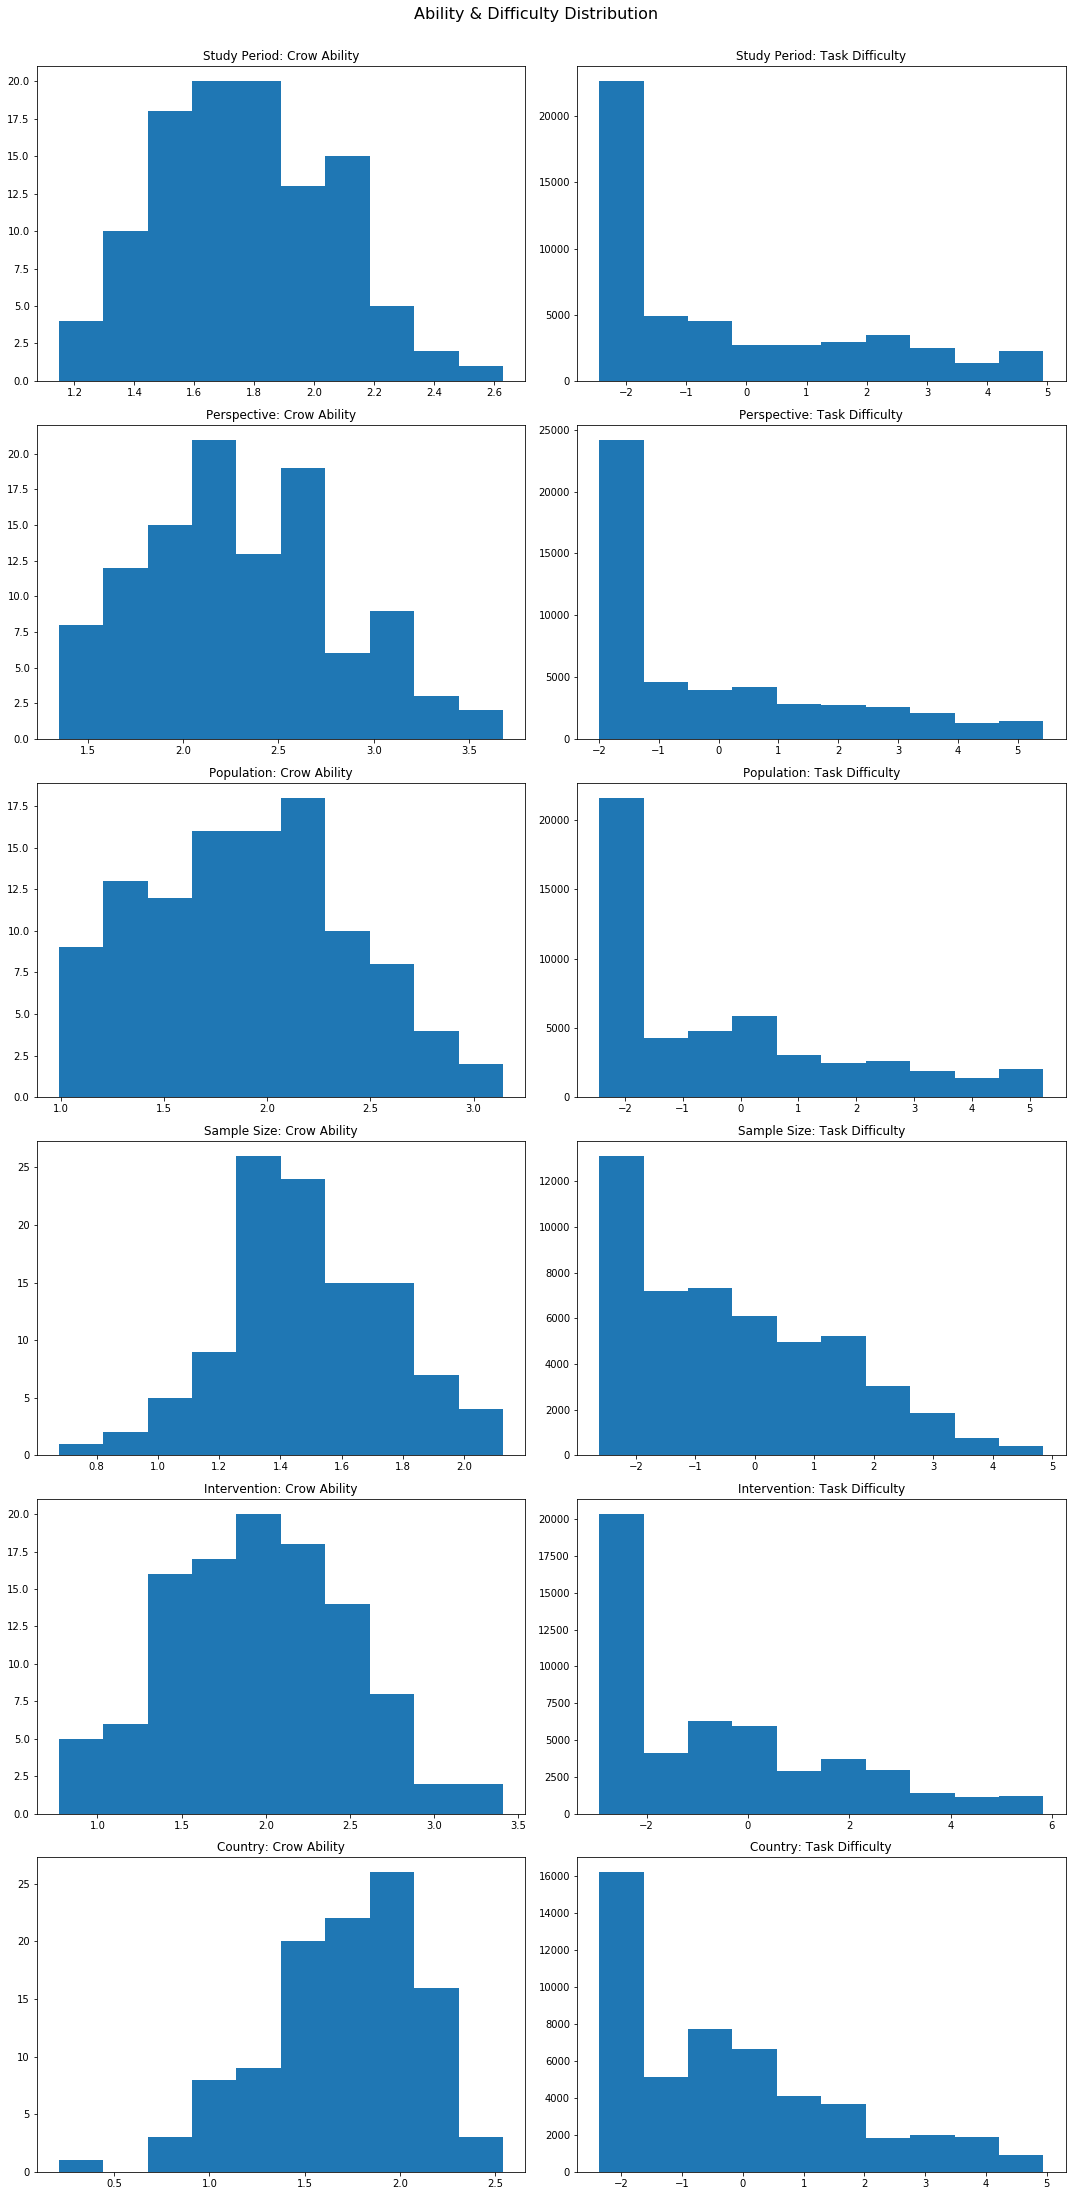

In [59]:
# overall
fig, axes = plt.subplots(len(col_names), 2, figsize=(15,30))
for i, cur_col in enumerate(col_names):
    axes[i][0].hist(ability_dfs[cur_col].iloc[:, 0])
    axes[i][0].title.set_text(cur_col + ': Crow Ability')
    axes[i][1].hist(diff_dfs[cur_col]['diff'])
    axes[i][1].title.set_text(cur_col + ': Task Difficulty')
fig.tight_layout()
fig.suptitle('Ability & Difficulty Distribution', size=16, y=1.015)
fig.savefig(os.path.join(cwd, 'saved_figures', 'overall_ability_difficulty.png'), bbox_inches='tight')
plt.show()

Train data(augmented)

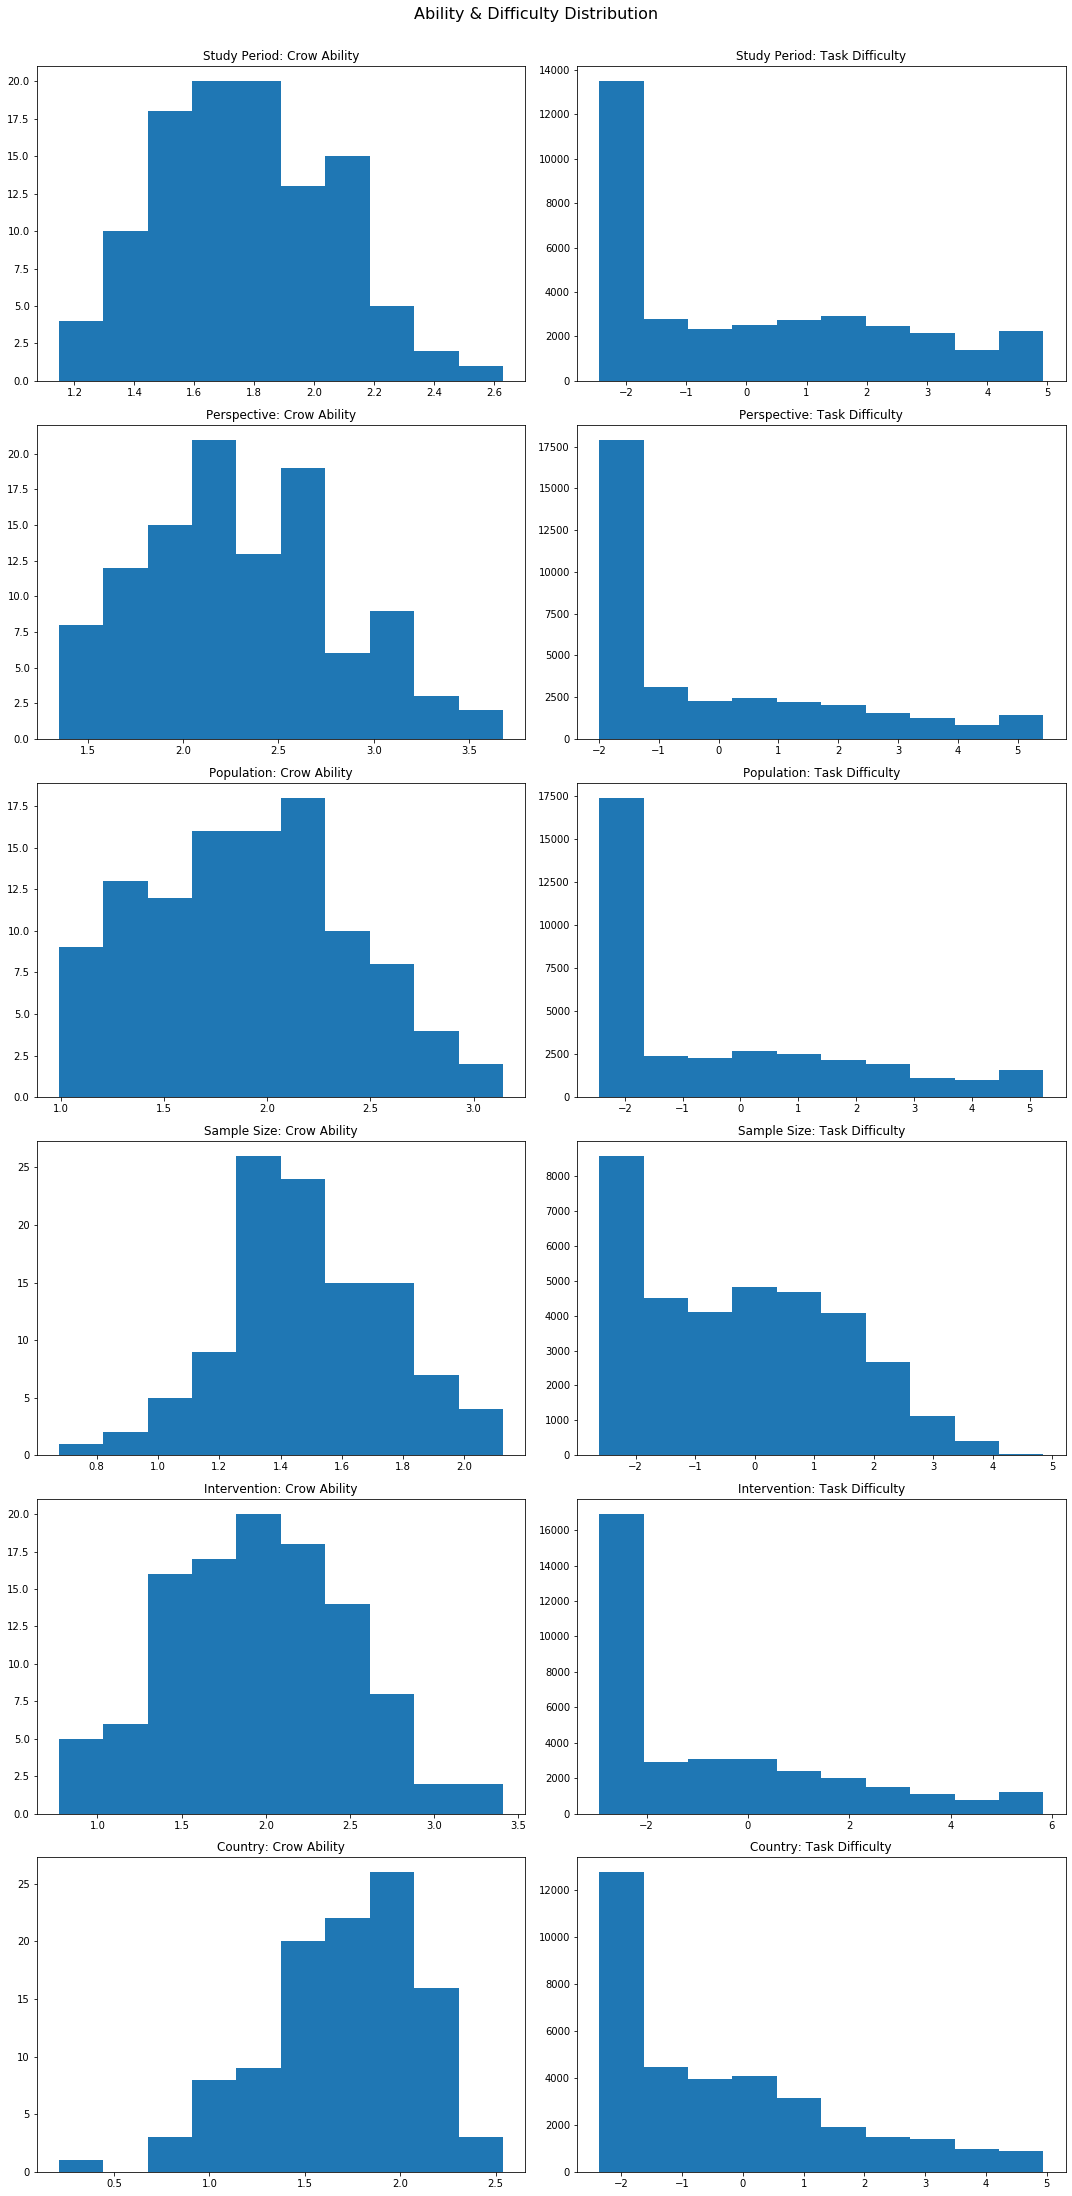

In [61]:
# train: augmented
fig, axes = plt.subplots(len(col_names), 2, figsize=(15,30))
for i, cur_col in enumerate(col_names):
    axes[i][0].hist(ability_dfs[cur_col].iloc[:, 0])
    axes[i][0].title.set_text(cur_col + ': Crow Ability')
    cur_diff_df = diff_dfs[cur_col]
    cur_diff_df = cur_diff_df[cur_diff_df['Train'] == True]
    axes[i][1].hist(cur_diff_df['diff'])
    axes[i][1].title.set_text(cur_col + ': Task Difficulty')
fig.tight_layout()
fig.suptitle('Ability & Difficulty Distribution', size=16, y=1.015)
fig.savefig(os.path.join(cwd, 'saved_figures', 'train(augmented)_ability_difficulty.png'), bbox_inches='tight')
plt.show()

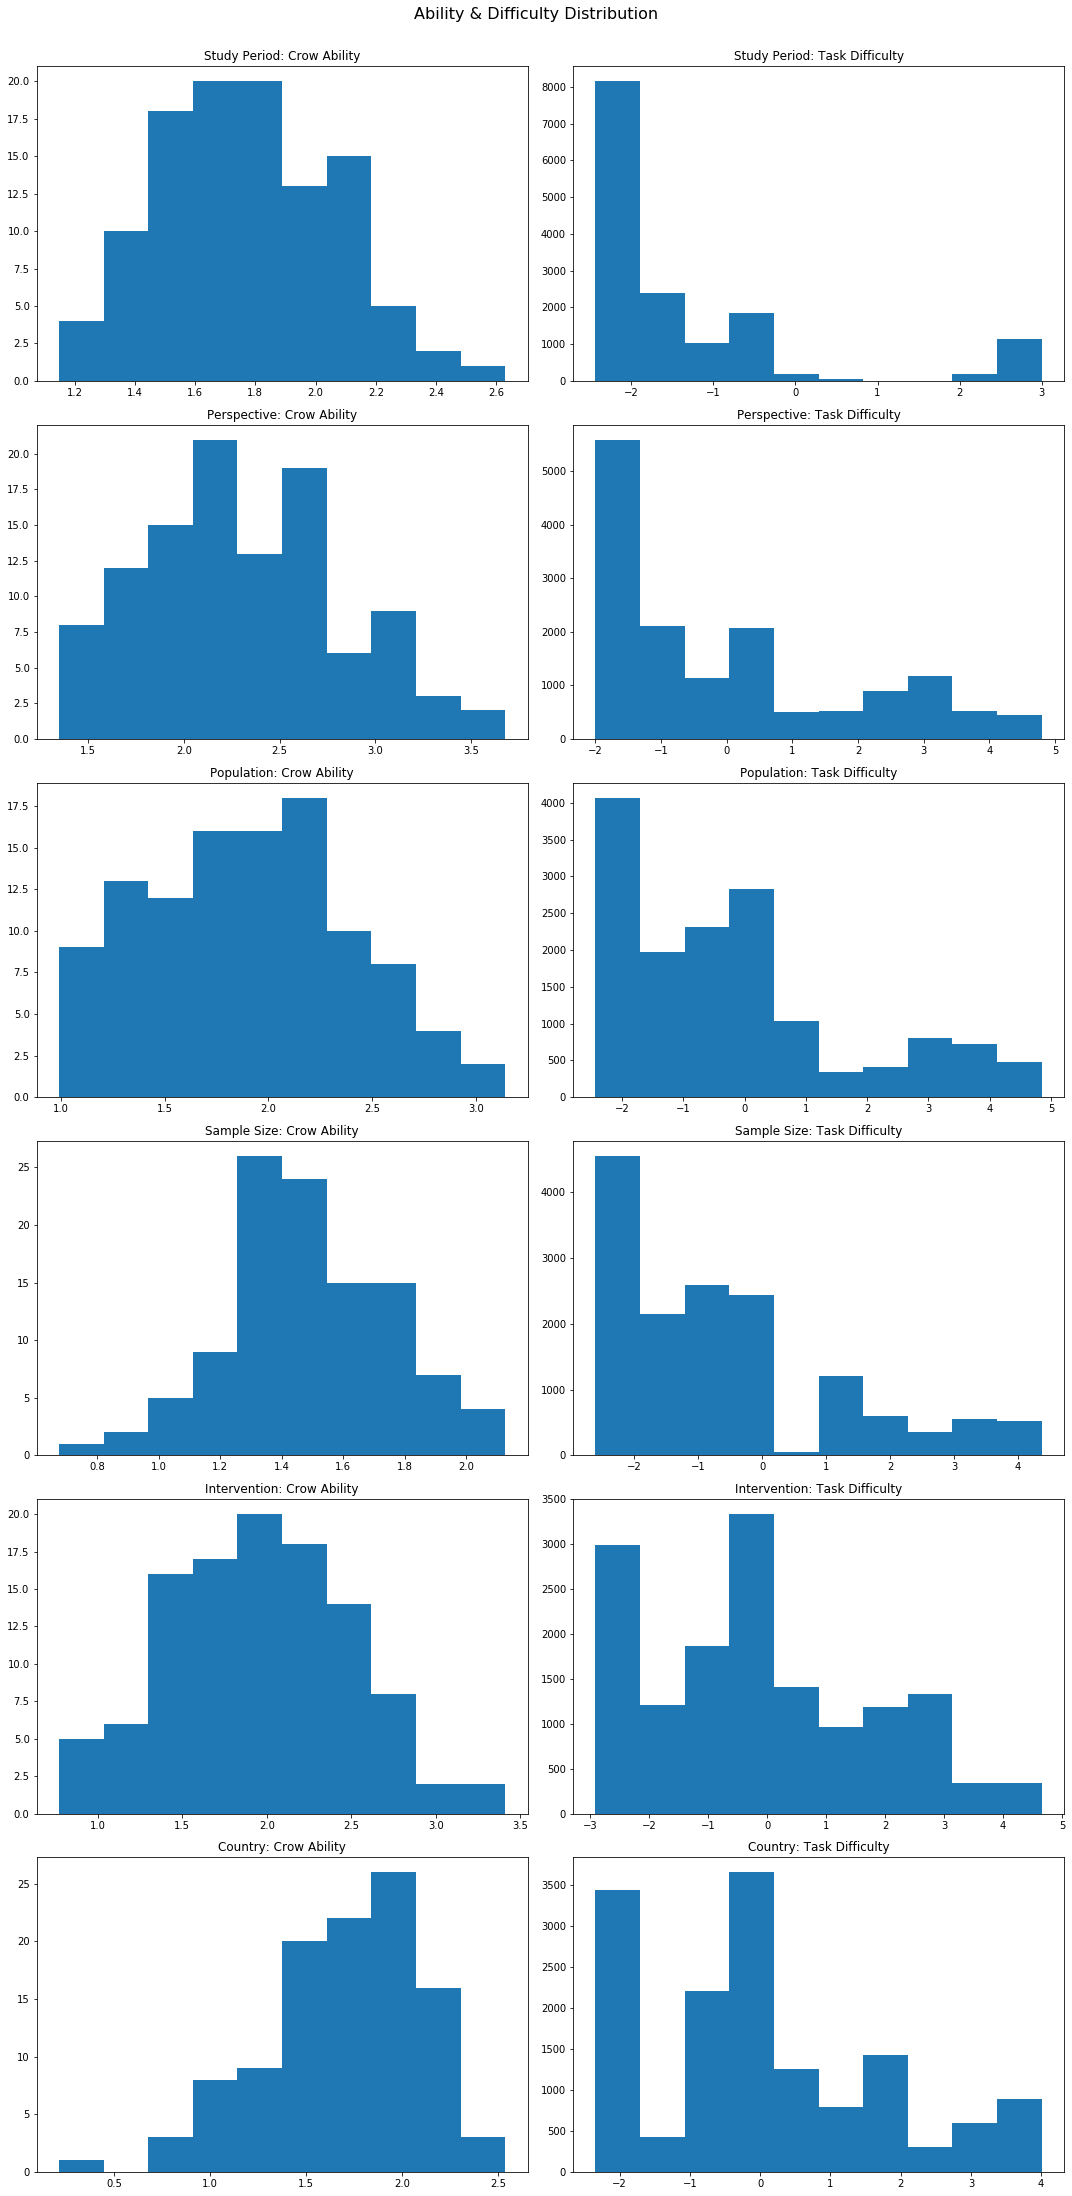

In [63]:
# valid: non-augmented
fig, axes = plt.subplots(len(col_names), 2, figsize=(15,30))
for i, cur_col in enumerate(col_names):
    axes[i][0].hist(ability_dfs[cur_col].iloc[:, 0])
    axes[i][0].title.set_text(cur_col + ': Crow Ability')
    cur_diff_df = diff_dfs[cur_col]
    cur_diff_df = cur_diff_df[cur_diff_df['Train'] == False]
    axes[i][1].hist(cur_diff_df['diff'])
    axes[i][1].title.set_text(cur_col + ': Task Difficulty')
fig.tight_layout()
fig.suptitle('Ability & Difficulty Distribution', size=16, y=1.015)
fig.savefig(os.path.join(cwd, 'saved_figures', 'valid(non-augmented)_ability_difficulty.png'), bbox_inches='tight')
plt.show()

## Task Accuracy

### Col Names

In [64]:
col_names = ['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country']

### Estimate Task Accuracy

In [ ]:
# function
def one_task_acc(the_task_id):
    judgements = []
    for i in range(100):
        cur_df = model_judgement_dfs[i]
        cur_judgement = cur_df[cur_df['ID'] == the_task_id]['Judgement'].iloc[0]
        judgements.append(cur_judgement)

    return np.sum(judgements) / len(judgements)

all_classes_acc_result = {}

for cur_col in col_names:
    print(f'{cur_col} started')
    # task difficulties
    fitted_param_path = os.path.join(cwd, 'total_data', 'fitted_IRT', cur_col, 'best_parameters.json')
    best_param_json = json.load(open(fitted_param_path))
    ids_key = list(best_param_json['item_ids'].keys())

    # ordering the id - ascending
    ids_key_number = [int(i) for i in ids_key]
    ids_key_number.sort()
    ids_key = [str(i) for i in ids_key_number]
    ids = [best_param_json['item_ids'][i] for i in ids_key]

    # difficulties df
    diff_df = pd.DataFrame({'ID': ids, 'diff': best_param_json['diff']})  # FIXME

    # model judgements
    model_judgement_dfs = [pd.read_csv(os.path.join(cwd, 'total_data', 'model_judgement', cur_col, str(i) + '.pth.csv')) for i in range(100)]
    task_IDs = diff_df['ID'].tolist()

    # calculate acc
    acc_result = p_map(one_task_acc, task_IDs, num_cpus=10)
    acc_result_df = pd.DataFrame({'ID': task_IDs, 'acc': acc_result})

    # append
    all_classes_acc_result[cur_col] = pd.merge(diff_df, acc_result_df, on='ID')

with open(os.path.join(cwd, 'total_data', 'all_classes_acc_result.pkl'), 'wb') as f:
    pickle.dump(all_classes_acc_result, f)

### Load from saved pickle

In [65]:
with open(os.path.join(cwd, 'total_data', 'all_classes_acc_result.pkl'), 'rb') as f:
    all_classes_acc_result = pickle.load(f)

all_classes_acc_result.keys()

dict_keys(['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country'])

In [68]:
all_classes_acc_result['Study Period']

,ID,diff,acc
0,f4397874-4921-4e0b-8a39-14dc8e5d2f20,0.700252,0.70
1,cffbcbbe-9110-4426-ab57-e405f25e58da,-0.342794,0.88
2,b97807ed-206d-4f34-8d2a-3ebe38c48ca5,-2.130745,1.00
3,7de8fb7b-1703-4596-b6df-22e2efaa28f2,-0.083428,0.87
4,e00866b2-fb26-486e-940b-9377b9f2f349,-2.308834,1.00
...,...,...,...
49980,a7bbecb9-1066-41d8-a3c2-4bbb6dc5e722,-1.757472,0.97
49981,eadef740-6e3b-4cd0-bb31-aa5255ba6f78,-1.007171,0.92
49982,736950ef-a6ff-4bad-9ac2-d4e516207c16,-1.258980,0.94
49983,7af36359-4a92-4e7a-bf5d-f2eb3aac50cb,2.967544,0.19


### Correlation Plot Difficulty v.s. Accuracy

Scatter Plot

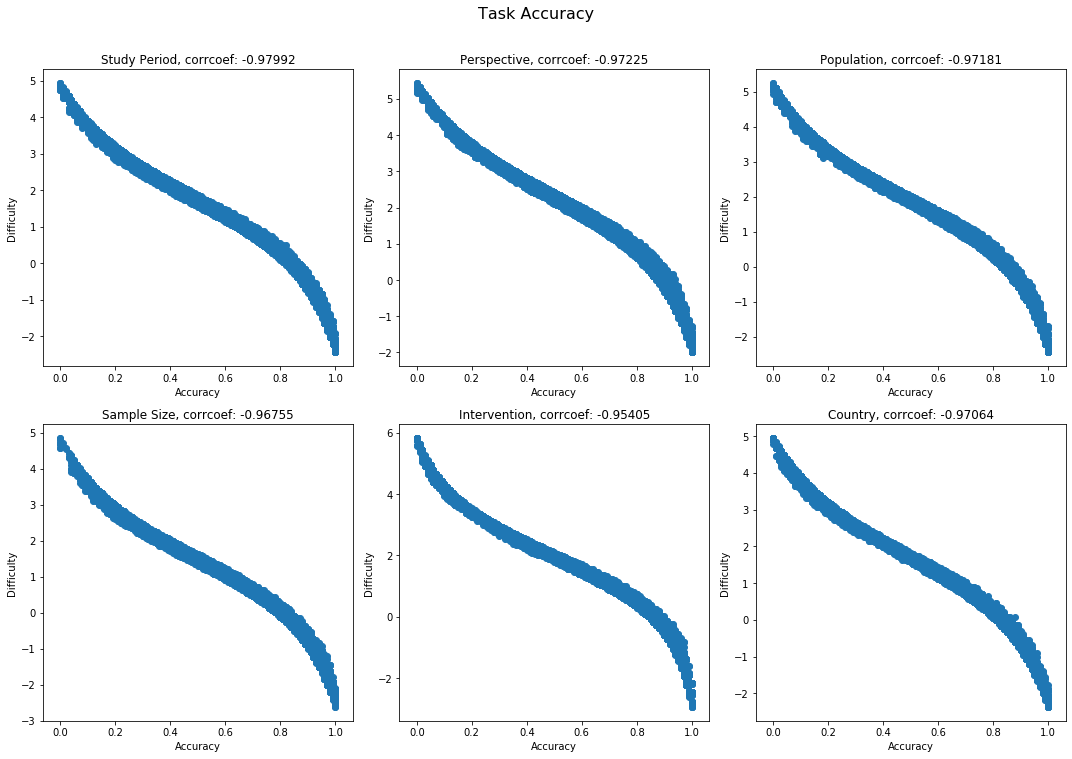

In [136]:
# overall
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
col_counter = 0
row_counter = 0
for i in range(6):
    cur_col = col_names[i]
    axes[col_counter][row_counter].scatter(all_classes_acc_result[cur_col]['acc'], all_classes_acc_result[cur_col]['diff'])
    cur_corr = np.corrcoef(all_classes_acc_result[cur_col]['diff'], all_classes_acc_result[cur_col]['acc'])[0][1]
    axes[col_counter][row_counter].title.set_text(cur_col + f', corrcoef: {round(cur_corr, 5)}')
    axes[col_counter][row_counter].set_xlabel('Accuracy')
    axes[col_counter][row_counter].set_ylabel('Difficulty')
    row_counter += 1
    if row_counter % 3 == 0:
        col_counter +=1
        row_counter = 0
fig.tight_layout()
fig.suptitle('Task Accuracy', size=16, y=1.05)
fig.savefig(os.path.join(cwd, 'saved_figures', 'task_diff_acc_corr.png'), bbox_inches='tight')
plt.show()

Accuracy Distribution

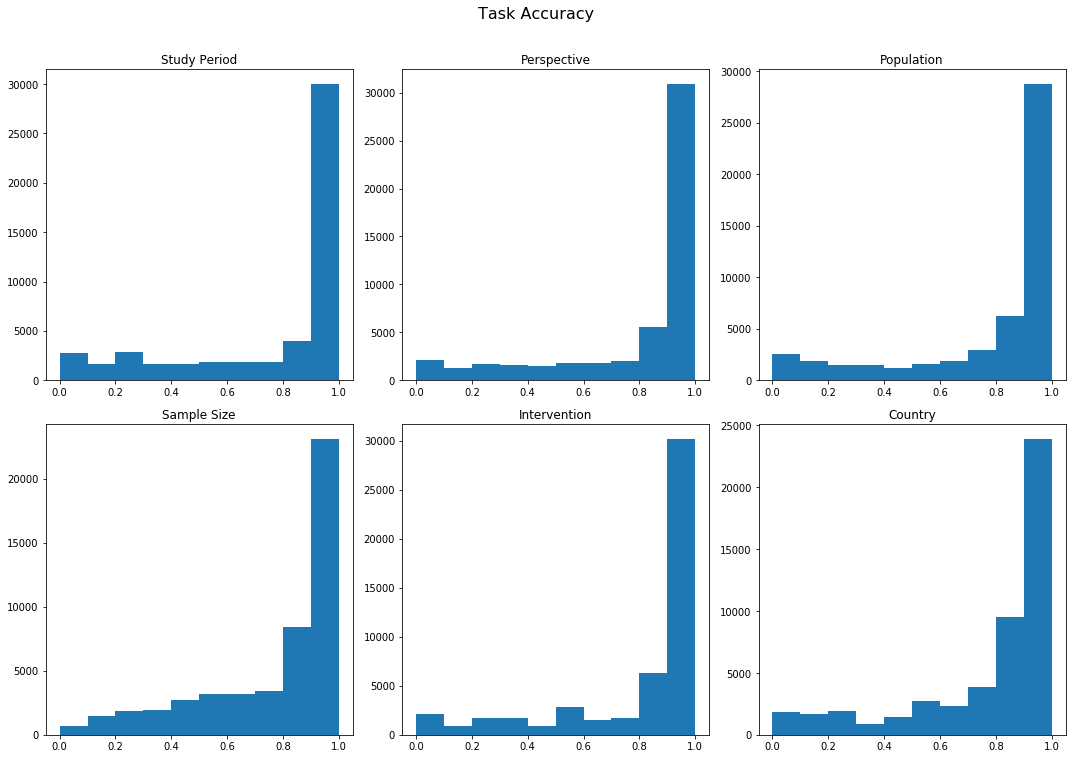

In [137]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
col_counter = 0
row_counter = 0
for i in range(6):
    cur_col = col_names[i]
    axes[col_counter][row_counter].hist(all_classes_acc_result[cur_col]['acc'])
    axes[col_counter][row_counter].title.set_text(cur_col)
    row_counter += 1
    if row_counter % 3 == 0:
        col_counter +=1
        row_counter = 0
fig.tight_layout()
fig.suptitle('Task Accuracy', size=16, y=1.05)
fig.savefig(os.path.join(cwd, 'saved_figures', 'task_acc_dist.png'), bbox_inches='tight')
plt.show()

## Crowd Accuracy v.s. Num Filters/Corruption Ratio

### Col Names

In [75]:
col_names = ['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country']

### Get Crowd Info Dfs & calculate the crowd acc

In [123]:
def calculate_crowd_acc_single(cur_model_judgement_path):
    # acc
    cur_df = pd.read_csv(cur_model_judgement_path)
    cur_acc = cur_df['Judgement'].mean()
    # crowd id
    cur_id = os.path.basename(cur_model_judgement_path).split('.')[0]
    cur_id = int(cur_id)

    return cur_id, cur_acc

def calculate_crowd_acc(cur_col_name):
    paths = glob.glob(os.path.join(cwd, 'total_data', 'model_judgement', cur_col_name, '*.csv'))
    results = p_map(calculate_crowd_acc_single, paths, num_cpus=10)

    ids = []
    accs = []
    for cur_item in results:
        ids.append(cur_item[0])
        accs.append(cur_item[1])

    return pd.DataFrame({'CrowdID': ids, 'Acc': accs})


crowd_info_dfs = {}
for cur_col in col_names:
    print(f'{cur_col} Started')
    cur_path = glob.glob(os.path.join(cwd, 'crowd', cur_col, '*.csv'))[0]
    cur_df = pd.read_csv(cur_path, index_col=0)
    cur_acc_df = calculate_crowd_acc(cur_col)
    cur_result_df = pd.merge(cur_df, cur_acc_df, on='CrowdID')
    cur_result_df['CorruptionRatio'] =  cur_result_df['CorruptionRatio'].round(2)
    crowd_info_dfs[cur_col] = cur_result_df

Study Period Started


  0%|          | 0/108 [00:00<?, ?it/s]

Perspective Started


  0%|          | 0/108 [00:00<?, ?it/s]

Population Started


  0%|          | 0/108 [00:00<?, ?it/s]

Sample Size Started


  0%|          | 0/108 [00:00<?, ?it/s]

Intervention Started


  0%|          | 0/108 [00:00<?, ?it/s]

Country Started


  0%|          | 0/108 [00:00<?, ?it/s]

In [124]:
crowd_info_dfs['Country']

,CrowdID,NumFilters,Direction,CorruptionRatio,Acc
0,0,5,neg,0.05,0.834551
1,1,10,pos,0.05,0.770143
2,2,15,neg,0.05,0.831669
3,3,20,neg,0.05,0.817483
4,4,25,neg,0.05,0.804758
...,...,...,...,...,...
103,103,25,neg,0.60,0.780568
104,104,30,pos,0.60,0.719622
105,105,35,neg,0.60,0.793593
106,106,40,neg,0.60,0.804558


In [125]:
crowd_info_dfs['Country']['CorruptionRatio'].iloc[107]

0.6

### Generate Heatmap

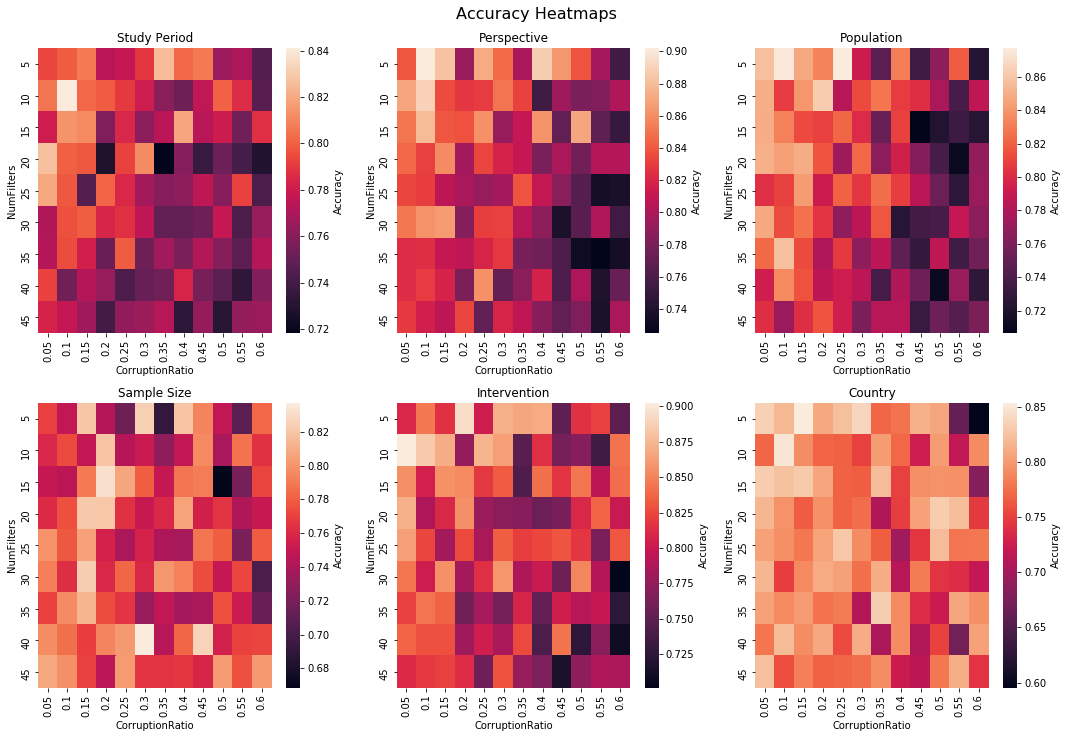

In [135]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
col_counter = 0
row_counter = 0
for i in range(6):
    cur_col = col_names[i]
    sns.heatmap(crowd_info_dfs[cur_col].pivot('NumFilters', 'CorruptionRatio', 'Acc'), ax=axes[col_counter][row_counter],  cbar_kws={'label': 'Accuracy'})
    axes[col_counter][row_counter].title.set_text(cur_col)
    row_counter += 1
    if row_counter % 3 == 0:
        col_counter +=1
        row_counter = 0
fig.tight_layout()
fig.suptitle('Accuracy Heatmaps', size=16, y=1.02)
fig.savefig(os.path.join(cwd, 'saved_figures', 'crowd_acc_heatmap.png'), bbox_inches='tight')
plt.show()

## Sorting Bug

In [3]:
fitted_param_path = os.path.join(cwd, 'total_data', 'fitted_IRT', 'Country', 'best_parameters.json')
best_param_json = json.load(open(fitted_param_path))
ids_key = list(best_param_json['item_ids'].keys())
ids_key_copy = ids_key.copy()
ids_key_copy.sort()

print(type(best_param_json))
print(best_param_json.keys())
print(f"# of Ability {len(best_param_json['ability'])}")
print(f"# of subject_ids {len(best_param_json['subject_ids'])}")
print(f"# of item_ids {len(best_param_json['item_ids'])}")
print(f"# of Diff {len(best_param_json['diff'])}")
print(best_param_json['irt_model'])

<class 'dict'>
dict_keys(['ability', 'diff', 'irt_model', 'item_ids', 'subject_ids'])
# of Ability 108
# of subject_ids 108
# of item_ids 49979
# of Diff 49979
1pl


In [4]:
# correct order
print(ids_key)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '15

In [5]:
# wrong order
print(ids_key_copy)

['0', '1', '10', '100', '1000', '10000', '10001', '10002', '10003', '10004', '10005', '10006', '10007', '10008', '10009', '1001', '10010', '10011', '10012', '10013', '10014', '10015', '10016', '10017', '10018', '10019', '1002', '10020', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '1003', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '1004', '10040', '10041', '10042', '10043', '10044', '10045', '10046', '10047', '10048', '10049', '1005', '10050', '10051', '10052', '10053', '10054', '10055', '10056', '10057', '10058', '10059', '1006', '10060', '10061', '10062', '10063', '10064', '10065', '10066', '10067', '10068', '10069', '1007', '10070', '10071', '10072', '10073', '10074', '10075', '10076', '10077', '10078', '10079', '1008', '10080', '10081', '10082', '10083', '10084', '10085', '10086', '10087', '10088', '10089', '1009', '10090', '10091', '10092', '10093', '10094', '10095', '10096', '10097', '10098', '1009